<a href="https://colab.research.google.com/github/SupermarketAutomationAI/baseline_model_SVM/blob/main/baseline_model_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading, Splitting, and Preprocessing

In [1]:
import os
import json
import math
import shutil
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import torchvision.models
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
from sklearn.metrics import confusion_matrix

#from models import *
#from utils import *
import sys, datetime, random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.patches as patches
from PIL import Image

import tensorflow as tf
import torchvision.transforms as T
import cv2


# imports
from sklearn import svm
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## Load the Data

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! rm -rf /root/datasets/V3_combined_all_DS/
# ! rm -rf /root/datasets/

In [4]:
# import zipfile
# Hooman + co
# ! unzip -uq '/content/drive/MyDrive/APS360 Project/Dataset Zip Files/V3_combined_all_DS.zip' -d '/root/datasets/'

# Jane
! unzip '/content/drive/MyDrive/APS360/V3_combined_all_DS-1' -d '/root/datasets/'

Streaming output truncated to the last 5000 lines.
  inflating: /root/datasets/__MACOSX/V3_combined_all_DS/Tomatoes/._Tamotoes00671.png  
  inflating: /root/datasets/V3_combined_all_DS/Tomatoes/._Tamotoes00671.png  
  inflating: /root/datasets/V3_combined_all_DS/Tomatoes/Tamotoes00117.png  
  inflating: /root/datasets/__MACOSX/V3_combined_all_DS/Tomatoes/._Tamotoes00117.png  
  inflating: /root/datasets/V3_combined_all_DS/Tomatoes/._Tamotoes00117.png  
  inflating: /root/datasets/V3_combined_all_DS/Tomatoes/Tamotoes002113.png  
  inflating: /root/datasets/__MACOSX/V3_combined_all_DS/Tomatoes/._Tamotoes002113.png  
  inflating: /root/datasets/V3_combined_all_DS/Tomatoes/._Tamotoes002113.png  
  inflating: /root/datasets/V3_combined_all_DS/Tomatoes/Tamotoes00842.png  
  inflating: /root/datasets/__MACOSX/V3_combined_all_DS/Tomatoes/._Tamotoes00842.png  
  inflating: /root/datasets/V3_combined_all_DS/Tomatoes/._Tamotoes00842.png  
  inflating: /root/datasets/V3_combined_all_DS/Tomatoes/Ta

In [5]:
# Clean the data, remove the metadate image files, marked with "._" in names
parent_dir = "/root/datasets/V3_combined_all_DS"

classes = ['Bananas', 'Carambola', 'Fuji Apples', 'Gala Apples', 'Golden Delicious Apples', 
           'Granny Smith Apples', 'Guava', 'Kiwi', 'Mango', 'Muskmelon', 'Oranges', 'Peach', 
           'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Red Delicious Apples', 
           'Tomatoes']

for cat in classes:
    path = parent_dir + '/' + cat
    invalid_files = glob(os.path.join(path,"._*"))
    for file_ in invalid_files:
        os.remove(file_)
    invalid_files = glob(os.path.join(path," ._*"))
    for file_ in invalid_files:
        os.remove(file_)
    print("Deleted image metadata files from {}".format(path))

Deleted image metadata files from /root/datasets/V3_combined_all_DS/Bananas
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Carambola
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Fuji Apples
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Gala Apples
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Golden Delicious Apples
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Granny Smith Apples
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Guava
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Kiwi
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Mango
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Muskmelon
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Oranges
Deleted image metadata files from /root/datasets/V3_combined_all_DS/Peach
Deleted image metadata files from /root/datasets/V3_combi

## Split the data

In [6]:
# create data directory and move all images into it
parent_dir = "/root/datasets/V3_combined_all_DS"
os.chdir(parent_dir)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
data_dir = parent_dir + '/' + "data"
os.mkdir(data_dir, 755)
for category in category_list:
    cat_dir = parent_dir + '/' + category
    shutil.move(cat_dir, data_dir)

In [7]:
train_split = 0.6

dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
 path = parent_dir + '/'+ dsdirs
 os.mkdir( path,755 )

for category in category_list: 
    src_path = parent_dir + '/data/' + category
    train_dir = parent_dir + '/train/' + category + '/'
    val_dir = parent_dir + '/val/' + category + '/'
    test_dir = parent_dir + '/test/' + category + '/'
    
    os.mkdir(train_dir, 755 )
    os.mkdir(val_dir, 755)
    os.mkdir(test_dir, 755)

    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]

    #get training, testing and validation files count
    train_count = math.ceil(train_split*len(files))
    valid_count = int((len(files)-train_count)/2)
    test_count = valid_count

    #get files to segragate for train,test and validation data set
    train_data_list = files[0: train_count-1]
    valid_data_list = files[train_count:train_count+valid_count-1] 
    test_data_list = files[train_count+valid_count:]


    for train_data in train_data_list:
        train_path = src_path + '/' + train_data
        shutil.move(train_path,train_dir)

    for valid_data in valid_data_list:
        valid_path = src_path + '/' + valid_data
        shutil.move(valid_path,val_dir)

    for test_data in test_data_list:
        test_path = src_path + '/' + test_data
        shutil.move(test_path,test_dir)

    # Move any files that are left behind into the training directory
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    for img_left_behind in files:
        img_path = src_path + '/' + img_left_behind
        shutil.move(img_path, train_dir)

## Preprocess data into Dataloaders

In [8]:
# Remove hidden files & directories that break data loader
dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
  path = parent_dir + '/'+ dsdirs
  !find $path -name '._*' -delete
  print("Deleted ._* files from {0}".format(path))

Deleted ._* files from /root/datasets/V3_combined_all_DS/train
Deleted ._* files from /root/datasets/V3_combined_all_DS/val
Deleted ._* files from /root/datasets/V3_combined_all_DS/test


In [9]:
# define the locations of the training and validation data
train_dir = os.path.join(parent_dir, 'train/')
val_dir = os.path.join(parent_dir, 'val/')
test_dir = os.path.join(parent_dir, 'test/')

# define a list of all classes that the model will be trained with

# List different classes: 19 currently
classes = ['Banana', 'Carambola', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
           'Granny_Smith_Apple', 'Guava', 'Kiwi', 'Mango', 'Orange', 
           'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate',
           'Red_Delicious_Apple', 'Tomatoes', 'muskmelon']

data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), 
                                        transforms.ToTensor()])

# apply the transforms to the data
train_data = datasets.ImageFolder(train_dir, transform=data_CC_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_CC_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_CC_transform)

# print the amount of data in both training and validation sets
print("Amount of training data: ", len(train_data))
print("Amount of validation data: ", len(val_data))
print("Amount of test data: ", len(test_data))

Amount of training data:  26970
Amount of validation data:  8987
Amount of test data:  8914


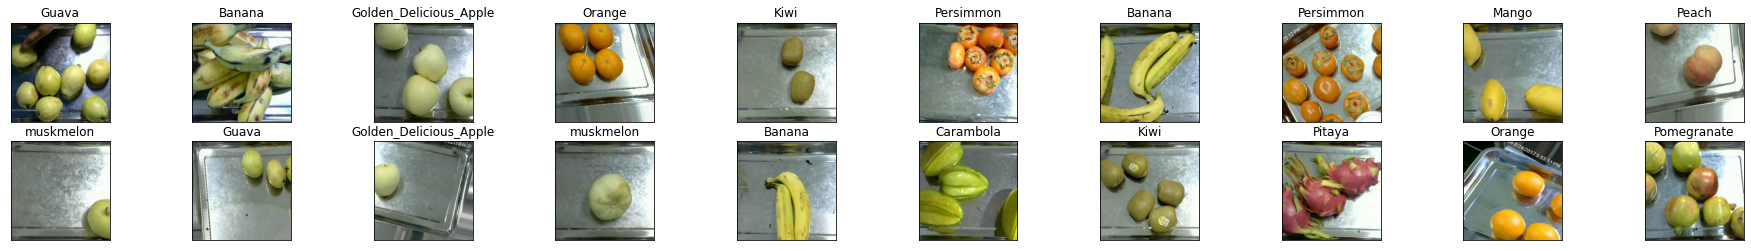

In [ ]:
# View 20 random, post processed, training images
fig = plt.figure(figsize=(32, 4)) 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

n=1
for data in iter(train_loader):
  img,label = data
  if n <= 20:
    image = img.numpy()
    ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
    plt.imshow(np.transpose(image[0], (1, 2, 0)))
    ax.set_title(classes[label])
    n = n+1
  else:
    break

In [ ]:
# set the batch_size
batch_size = 64

# define the locations of the training and validation data
train_dir = os.path.join(parent_dir, 'train/')
val_dir = os.path.join(parent_dir, 'val/')
test_dir = os.path.join(parent_dir, 'test/')


# three possible transforms, will test each to see which gives better results
data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

# apply the transforms to the data
train_data = datasets.ImageFolder(train_dir, transform=data_CC_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_CC_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_CC_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_data.__len__())
val_loader = torch.utils.data.DataLoader(val_data, batch_size=val_data.__len__())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_data.__len__())

# print the amount of data in both training and validation sets
print("Amount of training data: ", len(train_data))
print("Amount of validation data: ", len(val_data))
print("Amount of test data: ", len(test_data))

Amount of training data:  26966
Amount of validation data:  8966
Amount of test data:  8939


# Model Building, Training, and Testing

In [10]:
import random
def data_augmentation(img):
  '''
  Perform one of the following data augmentation techniques on the image
  Input img is expected to be a tensor
  Output is also a tensor
  '''
  aug_img = img
  #random.seed(1000)
  val = random.randint(0,5)
  if val is 0:
    aug_img = transforms.functional.gaussian_blur(img=img, kernel_size=13)
  elif val is 1:
    aug_img = transforms.functional.adjust_contrast(img=img, contrast_factor=0.55)
  elif val is 2:
    aug_img = transforms.functional.adjust_contrast(img=img, contrast_factor=1.55)
  elif val is 3:
    aug_img = transforms.functional.adjust_brightness(img=img, brightness_factor=0.45)
  elif val is 4:
    aug_img = transforms.functional.adjust_brightness(img=img, brightness_factor=1.66)
  elif val is 5:
    aug_img = transforms.functional.adjust_saturation(img=img, saturation_factor=0.55)
  #else return same image
  return aug_img

In [11]:
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [12]:
# save features with Alexnet
def get_alexnet_features(path, output_path, group, classes, data_aug=True, verify=False):
  '''
  path is where the images are
  output_path is where to store them
  group is [train, val, test]
  verify will show some sample output of images
  '''
  start_time = time.time()
  sc = StandardScaler()
  pca = decomposition.PCA(n_components=1)

  # ensure output path exists
  if os.path.exists(output_path) is False:
    os.mkdir(output_path)

  data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

  dataset = datasets.ImageFolder(os.path.join(path, group), transform=data_CC_transform)

  # load data with batch size of 1 since each image needs to be saved 1 at a time
  batch_size = 1
  num_workers = 1
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, shuffle=True)

  feature_path = os.path.join(output_path, group)
  print("Features saved to {}.".format(feature_path))
  if os.path.exists(feature_path):
    # may contain old data
    shutil.rmtree(feature_path)
    print("Found {} removed.".format(feature_path))
  os.mkdir(feature_path)

  n = 0
  fig = plt.figure(figsize=(32, 4)) #for verify later on
  print("Saving data features...")
  for img, label in loader: 
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
    folder_name = os.path.join(feature_path, str(classes[label]))
    if os.path.isdir(folder_name) is False:
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

    if data_aug is True:
      aug_img = data_augmentation(img)
      aug_features = alexnet.features(aug_img)
      aug_features_tensor = torch.from_numpy(aug_features.detach().numpy())
      torch.save(aug_features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1

    if verify is True and n <= 20:
      # verification step
      image = img.numpy() #convert to numpy for display
      ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
      plt.imshow(np.transpose(image[0], (1, 2, 0)))
      ax.set_title(classes[label[0]])

      # for augmented image
      if data_aug is True:
        aug_image = aug_img.numpy()
        ax = fig.add_subplot(2, 20/2, n-1, xticks=[], yticks=[])
        plt.imshow(np.transpose(aug_image[0], (1, 2, 0)))
        ax.set_title(classes[label[0]])

  end_time = time.time()
  print("Total time:  % 6.2f s" % ( end_time-start_time))
  return

In [13]:
feature_dir = "/root/datasets/features"
get_alexnet_features(parent_dir, output_path=feature_dir, group="train", classes=classes, data_aug=False, verify=False)

Features saved to /root/datasets/features/train.
Saving data features...
Total time:   966.77 s


<Figure size 2304x288 with 0 Axes>

In [16]:
get_alexnet_features(parent_dir, output_path="/root/datasets/features", group="val", classes=classes, data_aug=True, verify=False)
get_alexnet_features(parent_dir, output_path="/root/datasets/features", group="test", classes=classes, data_aug=True, verify=False)

Features saved to /root/datasets/features/val.
Saving data features...
Total time:   613.70 s
Features saved to /root/datasets/features/test.
Saving data features...
Total time:   569.44 s


<Figure size 2304x288 with 0 Axes>

<Figure size 2304x288 with 0 Axes>

In [17]:
def get_data_loader(path, batch_size=32, verify=True):
    '''
    Loads saved tensor files with features extracted using AlexNet
    '''
    # load tensor files from folder
    train_dataset = torchvision.datasets.DatasetFolder(path + '/train', loader=torch.load, extensions=('.tensor'))
    val_dataset = torchvision.datasets.DatasetFolder(path + '/val', loader=torch.load, extensions=('.tensor'))
    test_dataset = torchvision.datasets.DatasetFolder(path + '/test', loader=torch.load, extensions=('.tensor'))

    # # Prepare Dataloader
    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_dataset.__len__(),
                                             num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_dataset.__len__(),
                                             num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_dataset.__len__(),
                                             num_workers=num_workers, shuffle=True)

    # Verification Step - obtain one batch of features
    if verify is True:
      data_iter = iter(train_loader)
      features, labels = data_iter.next()
      print("Training Shape:")
      print(features.shape)
      print(labels.shape)

    return train_loader, val_loader, test_loader
    # return None, None, None

In [18]:
train_feature_loader, val_features_loader, test_feature_loader = get_data_loader(feature_dir, batch_size=64, verify=True)

Training Shape:
torch.Size([26970, 256, 6, 6])
torch.Size([26970])


## classification train/val accuracy

In [19]:
start = time.time()
dataiter = iter(train_feature_loader)
images, labels = dataiter.next()

sc = StandardScaler()
pca = decomposition.PCA(n_components=10)

images = images.view(images.shape[0], -1)
images = sc.fit_transform(images)
features = pca.fit_transform(images)

scaling = MinMaxScaler(feature_range=(-1,1)).fit(features)
features = scaling.transform(features)

clf = svm.SVC(kernel='poly')

clf.fit(features, labels)
# training accuracy
end_fit = time.time()
print("fit took {} sec".format(end_fit - start))
print(clf.score(features, labels))
end_score = time.time()
print("get score took {} sec".format(end_score - end_fit))

fit took -40.0034077167511 sec
0.810678531701891
get score took -15.223760604858398 sec


In [20]:
# validation accuracy
start = time.time()
dataiter = iter(val_features_loader)
images, labels = dataiter.next()

images = images.view(images.shape[0], -1)
images = sc.transform(images)
features = pca.transform(images)
features = scaling.transform(features)

val_acc = clf.score(features, labels)
end_val = time.time()
print(val_acc)
print("get val score took {} sec".format(end_val - start))

0.6377545343273617
get val score took 42.47094917297363 sec


## fasterRCNN

In [ ]:
#https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/
import torchvision
fasterrcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
fasterrcnn_model.eval()

In [28]:
def get_bb_prediction(img_path, threshold):
    img = Image.open(img_path).convert('RGB') # Load the image
    transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    pred = fasterrcnn_model([img]) # Pass the image to the fasterrcnn model
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = -1
    for x in pred_score:
        if (x > threshold):
            pred_t = pred_score.index(x)       
    pred_boxes = pred_boxes[:pred_t+1]
    return pred_boxes

In [30]:
def fast_fruit_bounding_box(img_path, model, classes, threshold=0.5, rect_th=2, text_size=0.5, text_th=2, txt_R=255, txt_G=255, txt_B=255):
  boxes = get_bb_prediction(img_path, threshold) # Get predictions, took out 'pred_cls' after boxes
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  
  transform = T.Compose([T.ToTensor()])
  img_tensor = transform(img)

  fruits_in_img = {}
  for cat in classes:
      fruits_in_img[cat] = 0

  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    top_left_y = int(boxes[i][0][1])
    top_left_x = int(boxes[i][0][0])
    height = int(abs(boxes[i][1][1] - boxes[i][0][1]))
    width = int(abs(boxes[i][1][0] - boxes[i][0][0]))
    img_cropped = T.functional.resized_crop(img_tensor, top_left_y, top_left_x, height, width, [224,224])
    img_cropped = img_cropped.unsqueeze(0)
    features = alexnet.features(img_cropped)
    out = model(features)
    pred_class = out.max(1, keepdim=True)[1]
    fruits_in_img[classes[pred_class[0]]] += 1
    cv2.putText(img,classes[pred_class[0]], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (txt_R,txt_G,txt_B),thickness=text_th) # Write the prediction class
  
  plt.figure(figsize=(10,15)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  if (len(boxes) == 0):
      print("I detect no fruits in this picture :(")
      return

  for fruit, number in fruits_in_img.items():
      if (number > 1):
          print("There are {} {}s in this image".format(number, fruit))
      elif (number == 1):
          print("There is {} {} in this image".format(number, fruit))

## bb

In [ ]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    pred = model([img]) # Pass the image to the model
    #pred_class = [FRUIT_RECOG_CATEGORY_NAMESV2[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[:pred_t+1]
    #pred_class = pred_class[:pred_t+1]
    return pred_boxes#, pred_class

In [ ]:
def object_detection_api(img_path, model, classes, threshold=0.5, rect_th=2, text_size=0.5, text_th=1):
  boxes = get_prediction(img_path, threshold) # Get predictions, took out 'pred_cls' after boxes
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB

  transform = T.Compose([T.ToTensor()])
  img_tensor = transform(img)

  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    top_left_y = int(boxes[i][0][1])
    top_left_x = int(boxes[i][0][0])
    height = int(abs(boxes[i][1][1] - boxes[i][0][1]))
    width = int(abs(boxes[i][1][0] - boxes[i][0][0]))
    img_cropped = T.functional.resized_crop(img_tensor, top_left_y, top_left_x, height, width, [224,224])
    img_cropped = img_cropped.unsqueeze(0)
    features = alexnet.features(img_cropped)
    out = model(features)
    print(out)
    pred_class = out.max(1, keepdim=True)[1]
    print(pred_class)
    cv2.putText(img,classes[pred_class[0]], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,0),thickness=text_th) # Write the prediction class
  
  plt.figure(figsize=(10,15)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
def object_detection_api_clf(img_path, model, classes, threshold=0.5, rect_th=2, text_size=0.5, text_th=1):
  boxes = get_prediction(img_path, threshold) # Get predictions, took out 'pred_cls' after boxes
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB

  transform = T.Compose([T.ToTensor()])
  img_tensor = transform(img)

  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    top_left_y = int(boxes[i][0][1])
    top_left_x = int(boxes[i][0][0])
    height = int(abs(boxes[i][1][1] - boxes[i][0][1]))
    width = int(abs(boxes[i][1][0] - boxes[i][0][0]))
    img_cropped = T.functional.resized_crop(img_tensor, top_left_y, top_left_x, height, width, [224,224])
    img_cropped = img_cropped.unsqueeze(0)
    features = alexnet.features(img_cropped)
    features = features.detach().numpy()

    features = torch.Tensor(features).view(1, -1)
    features = features.view(features.shape[0], -1)

    features = sc.transform(features)
    features = pca.transform(features)
    features = scaling.transform(features)

    out = clf.predict(features)
    print(out)
    cv2.putText(img,classes[out[0]], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,0),thickness=text_th) # Write the prediction class
  
  plt.figure(figsize=(10,15)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

[9]
[9]


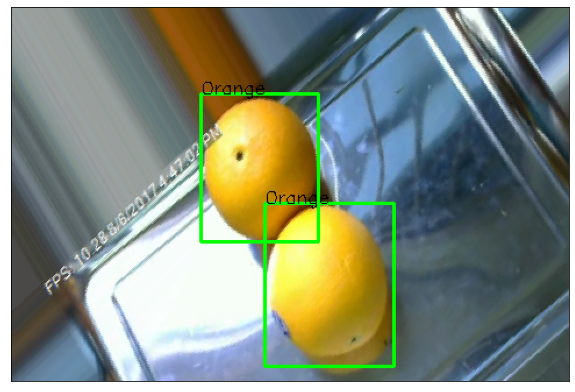

In [ ]:
# img_path = "/root/datasets/V2_combinedDS/train/Red_Delicious_Apple/107Red Delicious Apple 01001107.png"

# img_path = "/root/datasets/V3_combined_all_DS/val/Granny_Smith_Apple/Granny Smith Apple 00151.png"
img_path = "/root/datasets/V3_combined_all_DS/test/Orange/Orange00102.png"

object_detection_api_clf(img_path, clf, classes=classes, threshold=0.8)

## bb acc

In [22]:
'''
Modifying the ImageFolder class to store PIL 
Image path information as well as the image and its label.
'''
import torch
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

def get_data_loader_with_paths(train_dir, val_dir, test_dir, batch_size=1):
    data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

    train_dataset_with_paths = ImageFolderWithPaths(train_dir, transform=data_CC_transform)
    train_loader_with_paths = torch.utils.data.DataLoader(train_dataset_with_paths, batch_size=batch_size, shuffle=True)

    val_dataset_with_paths = ImageFolderWithPaths(val_dir, transform=data_CC_transform)
    val_loader_with_paths = torch.utils.data.DataLoader(val_dataset_with_paths, batch_size=batch_size, shuffle=True)

    test_dataset_with_paths = ImageFolderWithPaths(test_dir, transform=data_CC_transform)
    test_loader_with_paths = torch.utils.data.DataLoader(test_dataset_with_paths, batch_size=batch_size, shuffle=True)

    return train_loader_with_paths, val_loader_with_paths, test_loader_with_paths

def get_acc_data(data_dir, batch_size=1, num_images=200):
    # create acc directory and copy 200 images of each class into it
    acc_dir = "/root/datasets/V3_combined_all_DS/acc"
    if os.path.exists(acc_dir) == False:
        os.mkdir(acc_dir)
    os.chdir(data_dir)
    category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
    for category in category_list:
        n =  1
        cat_source_dir = os.path.join(data_dir,category)
        cat_dest_dir = os.path.join(acc_dir, category)
        if os.path.exists(cat_dest_dir) == False:
            os.mkdir(cat_dest_dir)
        files = glob(os.path.join(cat_source_dir,"*.png"))
        for file_ in files:
            if (n > num_images):
                break
            cat_source_file = os.path.join(cat_source_dir, file_)
            cat_dest_file = cat_dest_dir + '/' + file_.split('/')[-1]
            shutil.copyfile(cat_source_file, cat_dest_file)
            n += 1
    return

def get_data_loader_wpaths(data_dir, batch_size=1, shuffle=True):
    data_CC_transform = transforms.Compose([transforms.CenterCrop([224,224]), transforms.ToTensor()])

    dataset_with_paths = ImageFolderWithPaths(data_dir, transform=data_CC_transform)
    loader_with_paths = torch.utils.data.DataLoader(dataset_with_paths, batch_size=batch_size, shuffle=shuffle)

    return loader_with_paths

def get_feature_loader(path, group, batch_size=32, verify=True):
    '''
    Loads saved tensor files with features extracted using AlexNet
    '''
    # load tensor files from folder
    dataset = torchvision.datasets.DatasetFolder(os.path.join(path, group), loader=torch.load, extensions=('.tensor'))
    # Prepare Dataloader
    num_workers = 1
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         num_workers=num_workers, shuffle=True)

    # Verification Step - obtain one batch of features
    if verify is True:
      data_iter = iter(loader)
      features, labels = data_iter.next()
      print("Data Shape:")
      print(features.shape)
      print(labels.shape)

    return loader


def get_alexnet_features_bb_imp(path, output_path, group, classes, data_aug=False, verify=False, threshold=0.8):
  '''
  getting alexnet features using bounding box implementation
  path is where the images are, DATASET MUST HAVE PATH INFORMATION FOR EACH IMAGE
  output_path is where to store them
  group is [train, val, test]
  verify will show some sample output of images
  '''
  start_time = time.time()
  # ensure output path exists
  if os.path.exists(output_path) is False:
    os.mkdir(output_path)

  loader = get_data_loader_wpaths(os.path.join(path, group), batch_size=1, shuffle=False)

  feature_path = os.path.join(output_path, group)
  print("Features saved to {}.".format(feature_path))
  if os.path.exists(feature_path):
    # may contain old data
    shutil.rmtree(feature_path)
    print("Found {} removed.".format(feature_path))
  os.mkdir(feature_path)

  fig = plt.figure(figsize=(32, 4)) #for verify later on
  n = 0
  cant_detect = 0
  print("Saving data features...")
  for img, label, path in loader:
    img_boxes = get_bb_prediction(path[0], threshold)
    img_plt = cv2.imread(path[0])

    if (len(img_boxes) == 0):
      cant_detect += 1

    for i in range(len(img_boxes)):
      cv2.rectangle(img_plt, img_boxes[i][0], img_boxes[i][1],color=(0, 255, 0), thickness=2)
      top_left_y = int(img_boxes[i][0][1])
      top_left_x = int(img_boxes[i][0][0])
      height = int(abs(img_boxes[i][1][1] - img_boxes[i][0][1]))
      width = int(abs(img_boxes[i][1][0] - img_boxes[i][0][0]))
      img_PIL = Image.fromarray(img_plt)
      img_cropped = T.functional.resized_crop(img_PIL, top_left_y, top_left_x, height, width, [224,224])
      transform = T.Compose([T.ToTensor()])
      img_cropped_tensor = transform(img_cropped)
      img_cropped_tensor = img_cropped_tensor.unsqueeze(0)
      features = alexnet.features(img_cropped_tensor)
      features_tensor = torch.from_numpy(features.detach().numpy())

      folder_name = os.path.join(feature_path, str(classes[label]))
      if os.path.isdir(folder_name) is False:
        os.mkdir(folder_name)

      torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1

      if data_aug is True:
        aug_img = data_augmentation(img_cropped_tensor)
        aug_features = alexnet.features(aug_img)
        aug_features_tensor = torch.from_numpy(aug_features.detach().numpy())
        torch.save(aug_features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
        n += 1

      if verify is True and n <= 20:
        # verification step
        image = img_cropped_tensor.numpy() #convert to numpy for display
        ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
        plt.imshow(np.transpose(image[0], (1, 2, 0)))
        ax.set_title(classes[label[0]])

        # for augmented image
        if data_aug is True:
          aug_image = aug_img.numpy()
          ax = fig.add_subplot(2, 20/2, n-1, xticks=[], yticks=[])
          plt.imshow(np.transpose(aug_image[0], (1, 2, 0)))
          ax.set_title(classes[label[0]])

  end_time = time.time()
  print("Total time:  % 6.2f s" % ( end_time-start_time))
  return cant_detect



In [48]:
def get_accuracy_v2(model, data_loader, total=0):

    correct = 0
    if (len(data_loader)==0):
      return
    for imgs, labels in data_loader:
        features = imgs.view(imgs.shape[0], -1)
        features = sc.transform(features)
        features = pca.transform(features)
        features = scaling.transform(features)
        pred = model.predict(features)
        #select index with maximum prediction score
        # pred = output.max(1, keepdim=True)[1]
        pred = torch.tensor(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    print("total: {}, correct: {}".format(total, correct))
    return correct / total

In [31]:
! rm -rf "/root/datasets/features/acc"
! rm -rf "/root/datasets/V3_combined_all_DS/acc"
test_dir = "/root/datasets/V3_combined_all_DS/test"
get_acc_data(test_dir, batch_size=1, num_images=10)
path = "/root/datasets/V3_combined_all_DS"
# acc_features_dir = "/root/datasets/V3_combined_all_DS_features"
acc_features_dir = feature_dir
group = "acc"
cant_detect = get_alexnet_features_bb_imp(path, acc_features_dir, group, classes, data_aug=False, verify=False, threshold=0.8)

Features saved to /root/datasets/features/acc.
Saving data features...
Total time:   1219.89 s


<Figure size 2304x288 with 0 Axes>

In [32]:
acc_feature_loader = get_feature_loader(acc_features_dir, group, batch_size=1, verify=True)

Data Shape:
torch.Size([1, 256, 6, 6])
torch.Size([1])


In [49]:
supermarketAI_acc = get_accuracy_v2(clf, acc_feature_loader, total=cant_detect)

print("Supermarket AI accuracy on a subset of the Testing data, with bounding box implementation is: {:.2f}%".format(supermarketAI_acc*100))

total: 498, correct: 54
Supermarket AI accuracy on a subset of the Testing data, with bounding box implementation is: 10.84%
